The expectation and maximization algorithm is an iterative method to find (local) maximum likelihood or maximum a posterior (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables `Z`. 

The algorithm consists of two parts, the expectation (E) step, which computes the expectation of the log-likelihood of `Z` (the posterior of `Z`)evaluated using the current estimate for the parameters,  and the maximization (M) step, which updates parameter estimates maximizing the expected log-likelihood found on the E step. 

Here, we will implement E step and M step, and train a GMM using the EM algorithm. 

# E step


Implement the function which computs the posterior of latent variable $Z_i$'s given GMM parameters. 

In [3]:
def mixture_posterior_logits(x, logits, means, lsigmas):
  """Given log-unnormalized mixture weights, shift, and log scale parameters
  for mixture components, return the posterior of latent z_i's.
  Args:
      x: N x 1 tensor of 1d targets to get posteriors for.
      logits: ncomp tensor of mixing priors of mixture model
      means: ncomp tensor of means of mixture model.
      lsigmas: ncomp tensor of log std. dev. of mixture model.
  Return:
      posterior_logits: N x ncomp  tensor logits for posterior of z_i's. 
  """
  #p(z=k|x) = pi(k)*N(x|mu_k,sigma_k)/sum(pi(k)*N(x|mu_k,sigma_k))
  n = len(x)
  mu = means
  sigma = tf.math.exp(lsigmas)
  pdf=tf.math.exp(-0.5*(x - mu)**2 / sigma**2)/(2*np.pi*sigma**2)**0.5
  numerator = tf.nn.softmax(logits)*pdf
  sum = tf.reduce_sum(numerator,1)
  # numerator /tf.reshape(sum,[n,1]) # the posterior probability p(z=k|x)
  #logits = tf.expand_dims(logits, 0)
  #return numerator /tf.reshape(sum,[n,1])  
  return tf.math.log(pdf) + logits

# M Step

The M step update the parameter estimates of the GMM given a current posterior.

In [19]:
def mstep(x, posterior):
  """Given log-unnormalized mixture weights, shift, and log scale parameters
  for mixture components, return the posterior of latent z_i's.
  Args:
      x: N x 1 tensor of 1d samples.
      posterior_logits: N x ncomp  tensor of posterior for z_i's; i.e. sums to
        1 along the second axis.
  Return:
      logits: ncomp tensor of new mixing priors of mixture model
      means: ncomp tensor of new means of mixture model.
      lsigmas: ncomp tensor of new log std. dev. of mixture model.
  """
  #ncomp = tf.shape(posterior)[1].numpy()
  numerator = tf.reduce_sum(posterior*x,0)
  sumprob = tf.reduce_sum(posterior,0) # sum w_(j,m) from m =1 to n 
  mu = numerator/ sumprob  #means
  xminusmusquare = (tf.tile(x,(1,5))-tf.transpose(mu))*(tf.tile(x,(1,5))-tf.transpose(mu))
  var = tf.reduce_sum(posterior*xminusmusquare,0)/sumprob #sigma^2
  sigma = tf.math.sqrt(var)
  logits = tf.reduce_mean(posterior,0) #logits 
  return logits, mu, tf.math.log(sigma) 

# Data Setup

We first enable GPUs for the notebook and then import packages of using. 

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Found GPU at: /device:GPU:0


We generate sample data based on the ground truth parameters.

In [6]:
gt_logits = tf.math.log([1/4, 1/4, 1/6, 1/6, 1/6])
gt_means = tf.convert_to_tensor([1.0, -0.5, -2, .5, 3])
gt_lsigmas = tf.math.log([.5, 1.0, .2, 0.1, .5])

In [7]:
def make_data(N, logits, means, lsigmas):
  z = tf.transpose(tf.random.categorical([logits], N))
  y = tf.random.normal((N, 1))
  sigma = tf.math.exp(lsigmas)
  x = y * tf.gather(sigma,z)+tf.gather(means,z)
  return x

We can plot the histogram of our training data. 

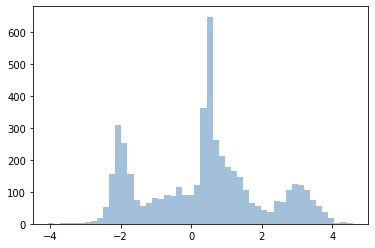

In [11]:
NUM_EXAMPLES = 5000
training_inputs = make_data(NUM_EXAMPLES, gt_logits, gt_means, gt_lsigmas)
plt.hist(np.reshape(training_inputs, [-1]), bins=50, alpha=0.5,
         histtype='stepfilled', color='steelblue', edgecolor='none');

We can plot our true likelihood using the ground truth parameters. The histogram above matches up with the likelihood plot here. 

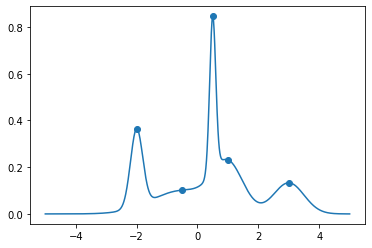

In [14]:
def mixture_likelihood(x, logits, means, lsigmas):
    """Given log-unnormalized mixture weights, shift, and log scale parameters
    for mixture components, return the likelihoods for targets.
    Args:
        x: N x 1 tensor of 1d targets to get likelihoods for.
        logits: ncomp tensor of mixing priors of mixture model.
        means: ncomp tensor of means of mixture model.
        lsigmas: ncomp tensor of log std. dev. of mixture model.
    Return:
        likelihoods: N x 1  tensor of likelihoods log p(x).
    """
    # Compute likelihoods per x
    # Write log likelihood with logsumexp.
    sigma = tf.math.exp(lsigmas)
    pdf = -1/2*((x-means)/sigma)**2 - 1/2*tf.math.log(2*np.pi*sigma**2) # logpdf take log of the pdf first
    logp = pdf+ tf.math.log(tf.nn.softmax(logits))
    return tf.reduce_logsumexp(logp,1)  # TODO

def plot_density(logits, means, lsigmas):
  gridx = np.reshape(np.linspace(-5.0, 5.0, 1000), [-1, 1])
  log_px = mixture_likelihood(gridx, logits, means, lsigmas)
  plt.plot(gridx, np.exp(log_px))
  plt.scatter(tf.reshape(means, [-1, 1]), np.exp(mixture_likelihood(tf.reshape(means, [-1, 1]), logits, means, lsigmas)))

plot_density(gt_logits, gt_means, gt_lsigmas)

# Implement EM model

Based on the above functions, we now implement a model that updates parameters using the E and M steps when called.

In [20]:
class EMGMM(tf.keras.Model):
  def __init__(self, k):
    super(EMGMM, self).__init__()
    self.logits = tf.Variable(tf.random.normal([k],0,0.1) , name='logits', trainable=False)
    self.means = tf.Variable(tf.random.normal([k],0,0.1), name='means',trainable=False) 
    self.lsigmas = tf.Variable(tf.random.normal([k],0,0.1), name='lsigmas',trainable=False) 
  def call(self, inputs):
    """
    E step
    """
    posterior = tf.nn.softmax(mixture_posterior_logits(inputs, self.logits, self.means, self.lsigmas), axis = -1)  # TODO
    """
    M step
    """
    new_logits, new_means, new_lsigmas = mstep(inputs, posterior) 

    self.logits.assign(new_logits)
    self.means.assign(new_means)
    self.lsigmas.assign(new_lsigmas)
    return None  # Shouldn't return anything


## Optimization 

We can train the model as follow. 

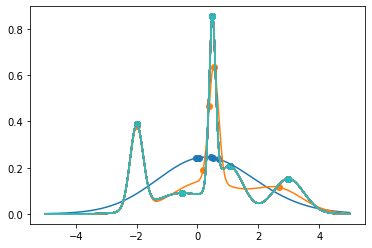

In [27]:
K = 5
model = EMGMM(K)

steps = 3000
for i in range(steps):
  model(training_inputs)
  if i % 100 == 0:
    #print(model.means)
    plot_density( model.logits, model.means, model.lsigmas)

And compare to the true likelihood. It shows that the training result is very similar to the true density.

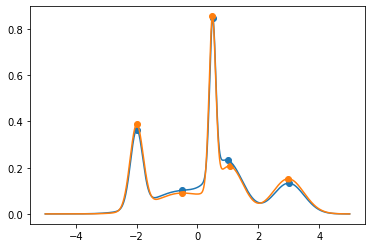

In [28]:
plot_density(gt_logits, gt_means, gt_lsigmas)
plot_density(model.logits, model.means, model.lsigmas)